In [65]:
from whoscored import *
import pandas as pd
from utils import *
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [66]:
BASE_DIR = os.path.join('..', 'data')
ENGINEERED_DIR = os.path.join(BASE_DIR, 'engineered')
SEASON_DIR = os.path.join(ENGINEERED_DIR, '2023')
MATCHES_DIR = os.path.join(SEASON_DIR, 'matches')


In [67]:
passes_df = get_all_passes_df(39, MATCHES_DIR)
passes_df

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType,match_period,angle,length
0,2.533998e+09,49.9,50.0,37.6,59.1,1232,397899.0,406255.0,Pass,Successful,FirstHalf,2.7,14.3
1,2.533998e+09,37.8,58.7,28.9,39.8,1232,406255.0,321846.0,Pass,Successful,FirstHalf,15.9,15.9
2,2.533998e+09,28.9,39.8,24.7,70.0,1232,321846.0,378598.0,Pass,Successful,FirstHalf,21.0,21.0
3,2.533998e+09,22.8,72.3,16.2,49.7,1232,378598.0,373523.0,Pass,Successful,FirstHalf,4.3,16.9
4,2.533998e+09,15.7,45.8,20.6,6.7,1232,373523.0,280413.0,Pass,Successful,FirstHalf,4.9,27.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,2.625924e+09,95.0,87.5,95.2,84.8,1232,284602.0,243212.0,Pass,Unsuccessful,SecondHalf,4.83,1.8
1001,2.625924e+09,99.5,99.5,96.7,62.1,1232,284602.0,86935.0,Pass,Unsuccessful,SecondHalf,25.6,25.6
1002,2.625924e+09,86.0,100.0,64.7,86.6,1232,93433.0,397585.0,Pass,Successful,SecondHalf,24.7,24.7
1003,2.625924e+09,66.4,77.3,64.3,58.8,1232,397585.0,401192.0,Pass,Successful,SecondHalf,4.54,12.8


In [68]:
train_test = passes_df.filter(['x', 'y', 'endX', 'endY','angle','length'])
train_test

,x,y,endX,endY,angle,length
0,49.9,50.0,37.6,59.1,2.7,14.3
1,37.8,58.7,28.9,39.8,15.9,15.9
2,28.9,39.8,24.7,70.0,21.0,21.0
3,22.8,72.3,16.2,49.7,4.3,16.9
4,15.7,45.8,20.6,6.7,4.9,27.1
...,...,...,...,...,...,...
1000,95.0,87.5,95.2,84.8,4.83,1.8
1001,99.5,99.5,96.7,62.1,25.6,25.6
1002,86.0,100.0,64.7,86.6,24.7,24.7
1003,66.4,77.3,64.3,58.8,4.54,12.8


In [84]:
X_train = train_test[30000:]
X_test = train_test[:6747]

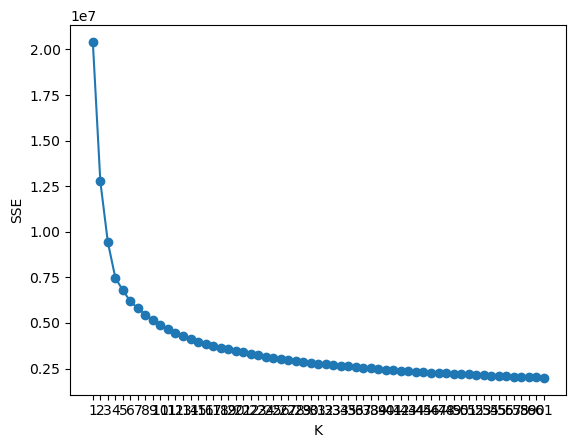

In [85]:
K = np.linspace(1, 61, 61)
X = X_train.values
elbow = {"sse": [], "k": [], "sil": []}
for k in K:
    cluster = KMeans(n_clusters = int(k), random_state = 2147)
    labels = cluster.fit_predict(X)
    elbow["sse"].append(cluster.inertia_)
    elbow["k"].append(k)

plt.scatter(elbow["k"], elbow["sse"])
plt.plot(elbow["k"], elbow["sse"])
plt.xticks(np.linspace(1, 61, 61))
plt.xlabel("K")
plt.ylabel("SSE")
plt.show()


In [86]:
from math import sqrt
def optimal_number_of_clusters(sse):
    x1, y1 = 2, sse[0]
    x2, y2 = 20, sse[len(sse)-1]

    distances = []
    for i in range(len(sse)):
        x0 = i+2
        y0 = sse[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2
optimal_number_of_clusters(elbow["sse"])

62

In [87]:
pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=62, random_state=2147))
])

pipeline.fit(X_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=62, random_state=2147))])

In [88]:
import warnings
warnings.filterwarnings("ignore")

In [89]:
train_labels = pipeline.predict(X_train)
X_train["cluster"] = train_labels
X_train

,x,y,endX,endY,angle,length,cluster
200,72.1,97.4,63.8,84.4,12.4,12.4,3
201,63.0,80.2,70.1,76.3,7.9,7.9,11
202,69.9,77.7,61.1,81.0,9.5,9.5,11
203,68.4,82.2,68.0,93.8,7.9,7.9,3
204,63.2,41.8,87.2,44.9,0.08,25.3,23
...,...,...,...,...,...,...,...
1000,95.0,87.5,95.2,84.8,4.83,1.8,42
1001,99.5,99.5,96.7,62.1,25.6,25.6,40
1002,86.0,100.0,64.7,86.6,24.7,24.7,42
1003,66.4,77.3,64.3,58.8,4.54,12.8,22


In [90]:
import matplotlib.pyplot as plt

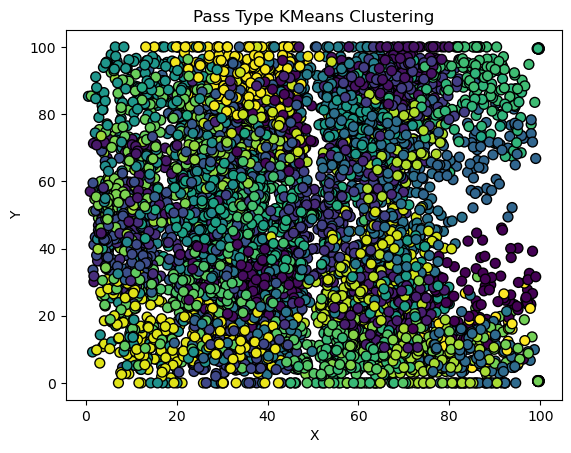

In [91]:

plt.scatter(X_train["x"], X_train["y"], c=X_train["cluster"], cmap='viridis', edgecolors='k', s=50)
plt.title('Pass Type KMeans Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [92]:
test_labels = pipeline.predict(X_test)
X_test["cluster"] = test_labels
X_test

,x,y,endX,endY,angle,length,cluster
0,49.9,50.0,37.6,59.1,2.7,14.3,38
1,37.8,58.7,28.9,39.8,15.9,15.9,43
2,28.9,39.8,24.7,70.0,21.0,21.0,28
3,22.8,72.3,16.2,49.7,4.3,16.9,47
4,15.7,45.8,20.6,6.7,4.9,27.1,8
...,...,...,...,...,...,...,...
881,99.5,0.5,93.0,51.7,1.76,35.5,61
882,55.8,6.4,68.4,4.6,6.19,13.3,41
883,59.1,24.3,84.4,49.7,31.7,31.7,48
884,51.9,29.1,56.0,31.3,4.6,4.6,5


In [93]:
from joblib import dump, load

In [94]:
MODELS_DIR = os.path.join(BASE_DIR, 'models')
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
filename = os.path.join(MODELS_DIR,'passes_clustering.joblib')
dump(pipeline, filename)

['..\\data\\models\\passes_clustering.joblib']

In [95]:
def clustering_pipeline(df):
    model = load(filename)
    cluster_df = df.filter(['x', 'y', 'endX', 'endY','angle','length'])
    labels = model.predict(cluster_df)
    df["cluster"] = labels
    return df

In [96]:
round_match = 9
data = get_data(round_match, MATCHES_DIR)
events_dict, players_df, teams_dict = extract_data_from_dict(data)


home_team_id = list(teams_dict.keys())[0]  # selected home team

In [97]:
flu_passes_df = passes_df.loc[passes_df["teamId"] == home_team_id]
flu_passes_df = clustering_pipeline(flu_passes_df)

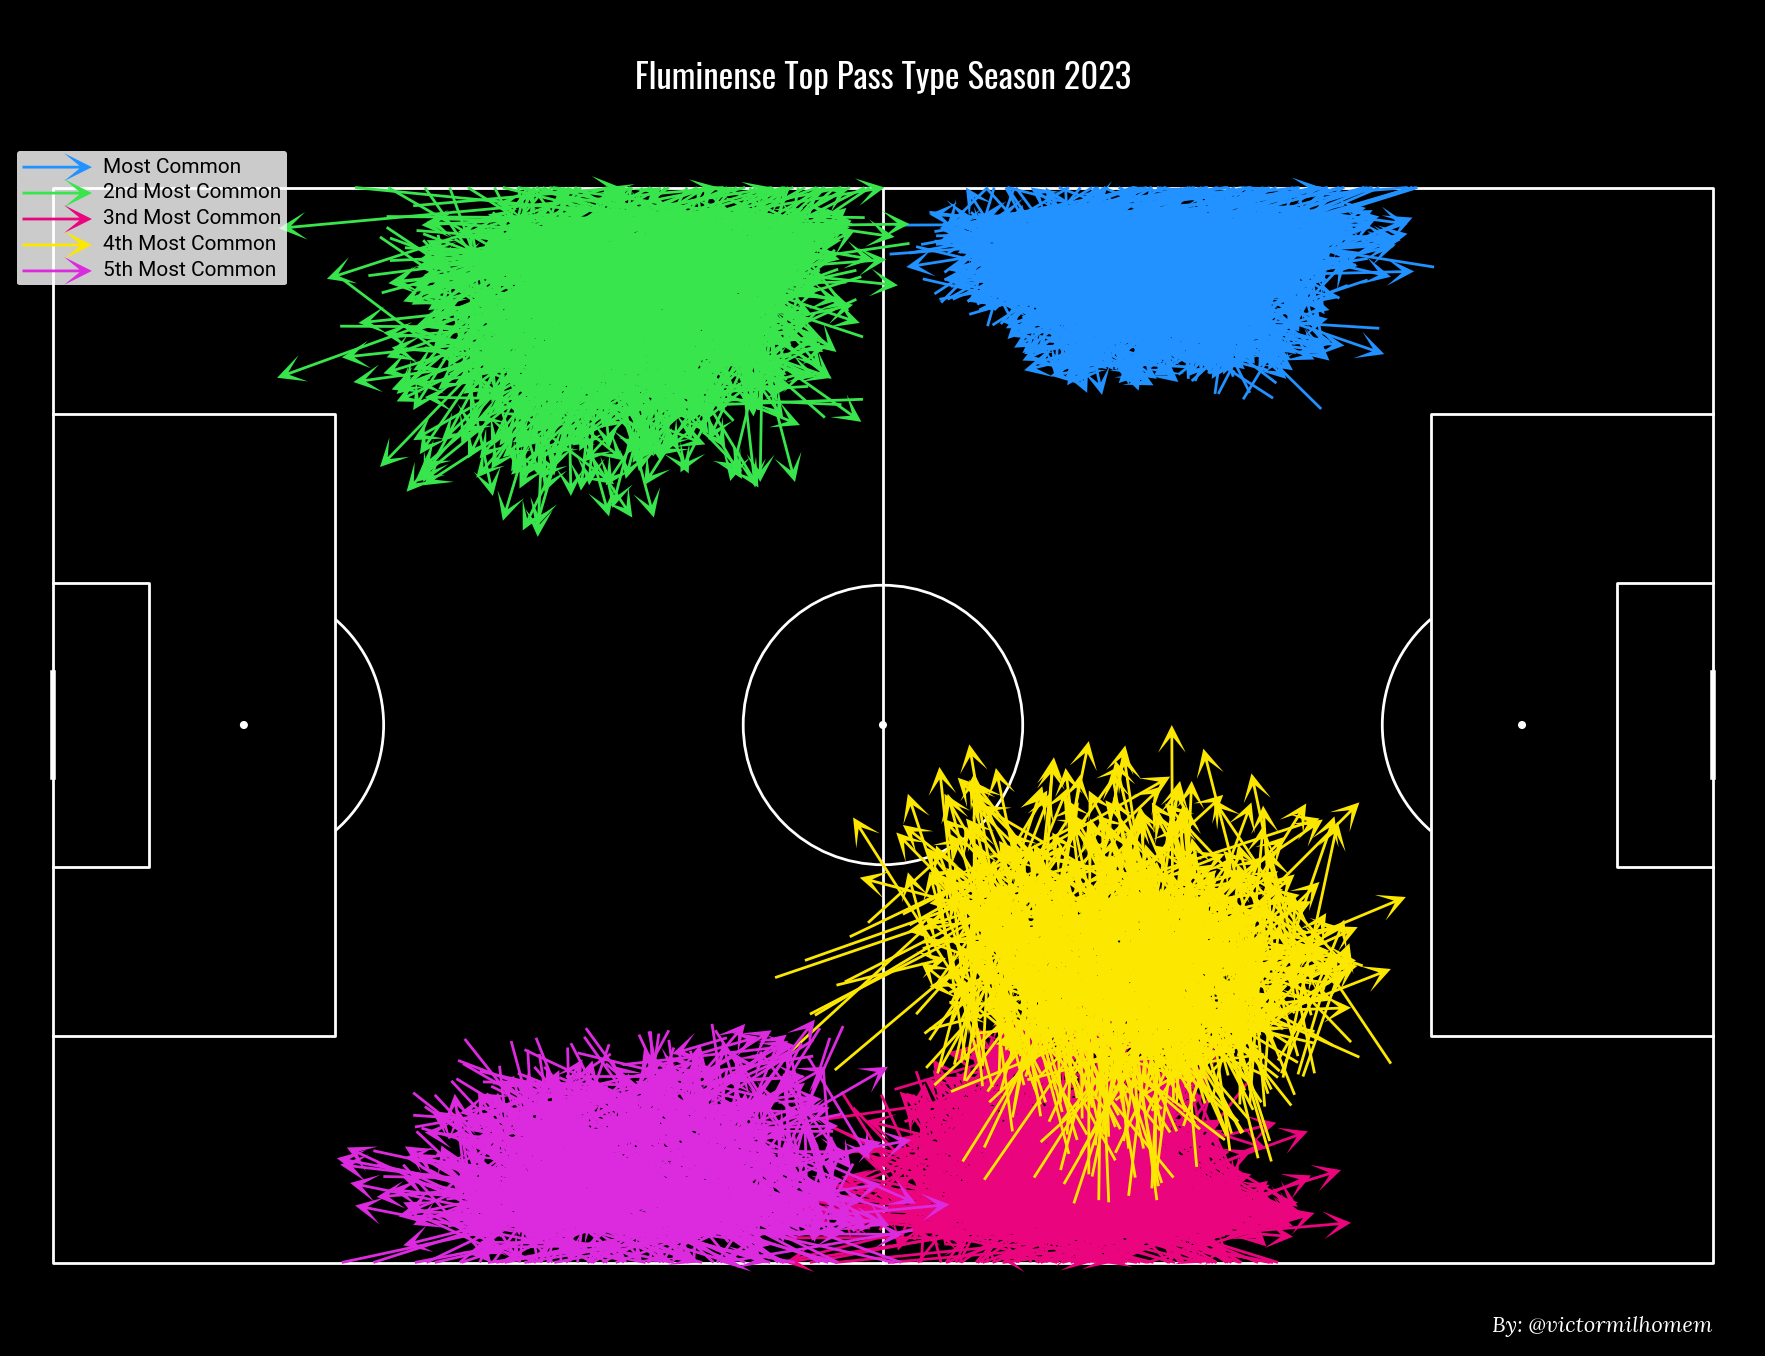

In [98]:
create_cluster_passes_map(flu_passes_df, f"Fluminense Top Pass Type Season 2023", credit="By: @victormilhomem")